# SHAP (SHapley Additive exPlanations) 

SHAP (SHapley Additive exPlanations) is a recent method for model interpretation that leverages game theory to help measure the impact of the features on the predictions. 

with the decision path method we have to traverse down the decision tree crediting each feature for the difference in the predictions. This can result in individual contributions that favor features found in splits lower in the tree. The SHAP method doesn't have that problem as it doesn't rely on the order of the features specified by the tree, instead it calculates the contributions by basically averaging the differences in predictions over every possible feature ordering

theoretically guarantees that SHAP is the only additive feature attribution method with three desirable properties:

   Local accuracy: The explanations are truthfully explaining the ML model

   Missingness: Missing features have no attributed impact to the model predictions

   Consistency: Consistency with human intuition (more technically, consistency states that if a model changes so that some input’s contribution increases or stays the same regardless of the other inputs, that input’s attribution should not decrease)


# Shapley Values

A prediction can be explained by assuming that each feature value of the instance is a “player” in a game where the prediction is the payout. Shapley values – a method from coalitional game theory – tells us how to fairly distribute the “payout” among the features.

You have trained a machine learning model to predict apartment prices. For a certain apartment it predicts €300,000 and you need to explain this prediction. The apartment has a size of 50 m2, is located on the 2nd floor, has a park nearby and cats are banned:

The average prediction for all apartments is €310,000. How much has each feature value contributed to the prediction compared to the average prediction?

The answer is simple for linear regression models. The effect of each feature is the weight of the feature times the feature value. This only works because of the linearity of the model. For more complex models, we need a different solution.

The “game” is the prediction task for a single instance of the dataset. The “gain” is the actual prediction for this instance minus the average prediction for all instances. The “players” are the feature values of the instance that collaborate to receive the gain (= predict a certain value).

In our apartment example, the feature values park-nearby, cat-banned, area-50 and floor-2nd worked together to achieve the prediction of €300,000. Our goal is to explain the difference between the actual prediction (€300,000) and the average prediction (€310,000): a difference of -€10,000.

## example how to calculate shap

In the following figure we evaluate the contribution of the cat-banned feature value when it is added to a coalition of park-nearby and size-50. We simulate that only park-nearby, cat-banned and size-50 are in a coalition by randomly drawing another apartment from the data and using its value for the floor feature. The value floor-2nd was replaced by the randomly drawn floor-1st. Then we predict the price of the apartment with this combination (€310,000). In a second step, we remove cat-banned from the coalition by replacing it with a random value of the cat allowed/banned feature from the randomly drawn apartment. In the example it was cat-allowed, but it could have been cat-banned again. We predict the apartment price for the coalition of park-nearby and size-50 (€320,000). The contribution of cat-banned was €310,000 - €320,000 = -€10.000.

This estimate depends on the values of the randomly drawn apartment that served as a “donor” for the cat and floor feature values. We will get better estimates if we repeat this sampling step and average the contributions.

We repeat this computation for all possible coalitions. The Shapley value is the average of all the marginal contributions to all possible coalitions. The computation time increases exponentially with the number of features. One solution to keep the computation time manageable is to compute contributions for only a few samples of the possible coalitions.

For each of these coalitions we compute the predicted apartment price with and without the feature value cat-banned and take the difference to get the marginal contribution

The Shapley value is the (weighted) average of marginal contributions. We replace the feature values of features that are not in a coalition with random feature values from the apartment dataset to get a prediction from the machine learning model.

If we estimate the Shapley values for all feature values, we get the complete distribution of the prediction among the feature values

### other explanation

The calculation of these values is simple but computationally expensive. As stated in the original SHAP paper, the idea is that you retrain the model on all feature subsets S ⊆ F, where F is the set of all features. Shapley values assign an importance value to each feature that represents the effect on the model prediction of including that feature. To compute this effect, a model is trained with that feature present, and another model is trained with the feature withheld. Then, predictions from the two models are compared on the current input i.e. their difference is computed. Since the effect of withholding a feature depends on other features in the model, the preceding differences are computed for all possible subsets of features. The Shapley values are a weighted average of all possible differences and are used as feature attributions.

# Examples and Interpretation

actual prediction 
average prediction
difference

The number of some fiture increased the probability the most. The sum of contributions yields the difference between actual and average prediction

Be careful to interpret the Shapley value correctly: The Shapley value is the average contribution of a feature value to the prediction in different coalitions. The Shapley value is NOT the difference in prediction when we would remove the feature from the model.

Nilai Shapley adalah kontribusi rata-rata dari nilai fitur terhadap prediksi dalam koalisi yang berbeda. Nilai Shapley BUKAN perbedaan dalam prediksi ketika kami akan menghapus fitur dari model.

 The interpretation of the Shapley value is: Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.

# Advantages

The difference between the prediction and the average prediction is fairly distributed among the feature values of the instance – the Efficiency property of Shapley values

This property distinguishes the Shapley value from other methods such as LIME. LIME does not guarantee that the prediction is fairly distributed among the features

The Shapley value allows contrastive explanations. Instead of comparing a prediction to the average prediction of the entire dataset, you could compare it to a subset or even to a single data point. This contrastiveness is also something that local models like LIME do not have.

The Shapley value is the only explanation method with a solid theory. The axioms – efficiency, symmetry, dummy, additivity – give the explanation a reasonable foundation. Methods like LIME assume linear behavior of the machine learning model locally, but there is no theory as to why this should work.

It is mind-blowing to explain a prediction as a game played by the feature values.

# Disadvantages

 a lot of computing time -- The exponential number of the coalitions is dealt with by sampling coalitions and limiting the number of iterations M. Decreasing M reduces computation time, but increases the variance of the Shapley value. There is no good rule of thumb for the number of iterations M. M should be large enough to accurately estimate the Shapley values, but small enough to complete the computation in a reasonable time. It should be possible to choose M based on Chernoff bounds, but I have not seen any paper on doing this for Shapley values for machine learning predictions.

The Shapley value can be misinterpreted. The Shapley value of a feature value is not the difference of the predicted value after removing the feature from the model training.

The Shapley value returns a simple value per feature, but no prediction model like LIME. This means it cannot be used to make statements about changes in prediction for changes in the input,  such as: “If I were to earn €300 more a year, my credit score would increase by 5 points.”

Another disadvantage is that you need access to the data if you want to calculate the Shapley value for a new data instance.

the Shapley value method suffers from inclusion of unrealistic data instances when features are correlated.

In [8]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import time

import sklearn

In [9]:
data = pd.read_csv('FIFA 2018 Statistics.csv')

y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary 0/1
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

In [ ]:
name = []
for i in range (0,18):
    name.append(str("{}_{}".format("x", i)))

In [ ]:
X.columns = name

# Permutation importance / feature importance

Permutation importance is computed after a model has been fitted. It answers the following question : If with randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy?

In [33]:
perm = PermutationImportance(my_model, random_state=1).fit(X_test, y_test)
display(eli5.show_weights(perm, feature_names = X.columns.tolist()))

Weight,Feature
0.1750 ± 0.0848,Goal Scored
0.0500 ± 0.0637,Distance Covered (Kms)
0.0437 ± 0.0637,Yellow Card
0.0187 ± 0.0500,Off-Target
0.0187 ± 0.0637,Free Kicks
0.0187 ± 0.0637,Fouls Committed
0.0125 ± 0.0637,Pass Accuracy %
0.0125 ± 0.0306,Blocked
0.0063 ± 0.0612,Saves
0.0063 ± 0.0250,Ball Possession %


In our example, the most important feature was Goals scored. The first number in each row shows how much model performance decreased with a random shuffling (in this case, using “accuracy” as the performance metric). We measure the randomness by repeating the process with multiple shuffles.

# Partial dependence plots

While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

Partial dependence plots can be interpreted similarly to coefficients in linear or logistic regression models but can capture more complex patterns than simple coefficients.

We can use partial dependence plots to answer questions like :

   Controlling for all other house features, what impact do longitude and latitude have on home prices? To restate this, how would similarly sized houses be priced in different areas?
    Are predicted health differences between the two groups due to differences in their diets, or due to some other factor?

### How does it work?

Partial dependence plots are calculated after a model has been fit. How do we then disentangle the effects of several features?

We start by selecting a single row. We will use the fitted model to predict our outcome of that row. But we repeatedly alter the value for one variable to make a series of predictions.

For example, in the football example used above, we could predict the outcome if the team had the ball 40% of the time, but also 45, 50, 55, 60, …

We build the plot by:
   representing on the horizontal axis the value change in the ball possession for example
   and on the horizontal axis the change of the outcome


In [10]:
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary 0/1
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(X_train, y_train)

In [11]:
y_probs = tree_model.predict_proba(X_test)
y_pred = tree_model.predict(X_test)

In [36]:
y_probs

array([[1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.04166667, 0.95833333],
       [0.        , 1.        ],
       [0.04166667, 0.95833333],
       [0.04166667, 0.95833333],
       [1.        , 0.        ],
       [0.65217391, 0.34782609],
       [0.04166667, 0.95833333],
       [0.65217391, 0.34782609],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.65217391, 0.34782609],
       [0.04166667, 0.95833333],
       [0.        , 1.        ],
       [0.04166667, 0.95833333],
       [0.65217391, 0.34782609],
       [0.65217391, 0.34782609],
       [0.4       , 0.6       ],
       [0.5       , 0.5       ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.65217391, 0.34782609],
       [0.65217391, 0.34782609],
       [1.        , 0.        ],
       [0.04166667, 0.95833333],
       [0.        , 1.        ],
       [0.

<IPython.core.display.Javascript object>


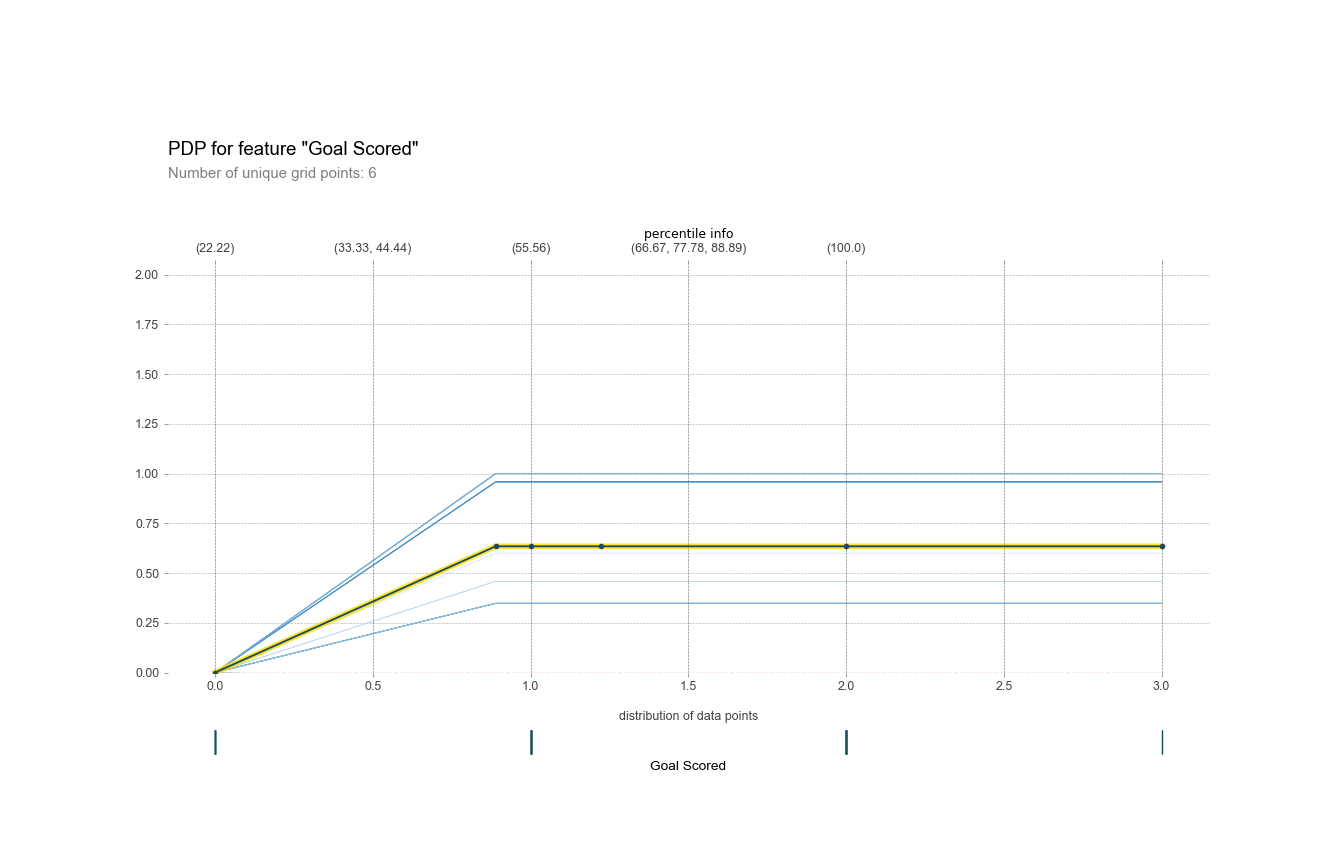

In [9]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=X_test, model_features=feature_names, feature='Goal Scored')

# plot it
pdp.pdp_plot(pdp_goals, 'Goal Scored',plot_pts_dist=True,center=True,x_quantile=False,plot_lines=True, show_percentile=True)
plt.show()

From this particular graph, we see that scoring a goal substantially increases your chances of winning “Man of The Match.” But extra goals beyond that appear to have little impact on predictions.

<IPython.core.display.Javascript object>


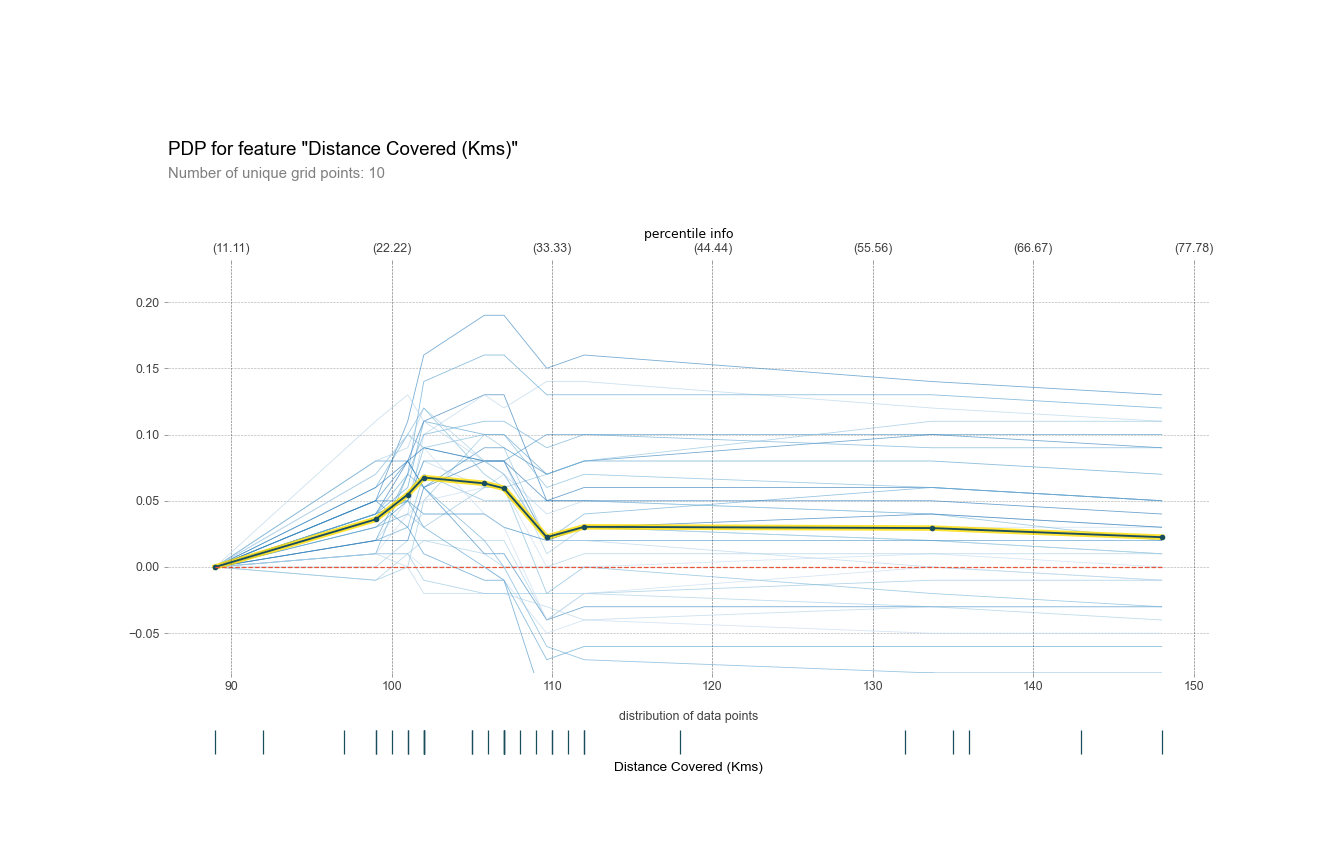

In [10]:
# Build Random Forest model
rf_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

feature_to_plot = "Distance Covered (Kms)"

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=X_test, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot,plot_pts_dist=True,center=True,x_quantile=False,plot_lines=True, show_percentile=True)
plt.show()

# 2D Partial Dependence Plots

<IPython.core.display.Javascript object>


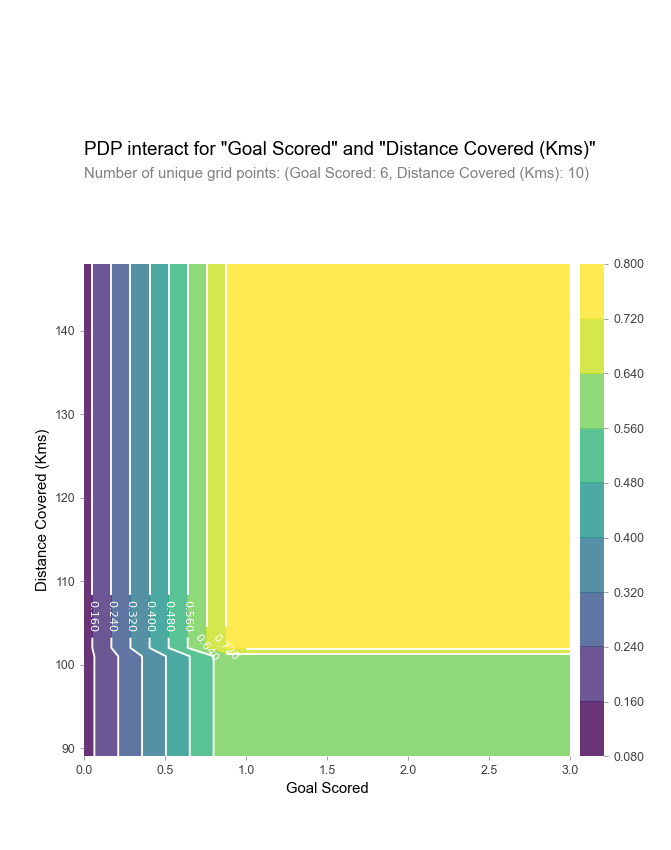

In [44]:
# Similar to previous PDP plot except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot

features_to_plot = ['Goal Scored', 'Distance Covered (Kms)']

inter1  =  pdp.pdp_interact(model=tree_model, dataset=X_test, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()


# SHAP Values

SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature.

This could be used for :
   banking automatic decision making
   healthcare risk factor assessment for a single person

In summary, we use SHAP values to explain individual predictions.

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we’d make if that feature took some baseline value.

### SHAP for sklearn

In [13]:
import shap  # package used to calculate Shap values

# row_to_show = 5
# data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
# data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

# Create object that can calculate shap values
# explainer = shap.TreeExplainer(my_model)
explainer = shap.KernelExplainer(my_model.predict_proba, X_train)

# Calculate Shap values
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

In [27]:
shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

The output value is 0.70. This is the prediction for the selected team. The base value is 0.4979. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature’s effect. Feature values decreasing the prediction are in blue. The biggest impact comes from Goal Scored being 2. Though the ball possession value has a meaningful effect decreasing the prediction.

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

The output prediction is 0.7, which means that the team is 70% likely to have a player win the award.

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset:

The above explanation shows almost all features contributing to push the model output from the base value (the average model output over the training dataset we passed) towards one. If there were any features pushing the class label lower they would be shown in blue.

In [47]:
def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == y_test)/len(y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

## another SHAP for sklearn

### KNN

In [48]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

print_accuracy(knn.predict)

Accuracy = 43.75%


In [49]:
explainer = shap.KernelExplainer(knn.predict_proba, X_train)
shap_values = explainer.shap_values(X_test.iloc[0,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0,:])

In [50]:
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

### Support vector machine with a linear kernel

In [52]:
svc_linear = sklearn.svm.SVC(kernel='linear', probability=True)
svc_linear.fit(X_train, y_train)
print_accuracy(svc_linear.predict)

# explain all the predictions in the test set
explainer = shap.KernelExplainer(svc_linear.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

Accuracy = 78.125%


### Support vector machine with a radial basis function kernel

In [ ]:
svc_linear = sklearn.svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, y_train)
print_accuracy(svc_linear.predict)

# explain all the predictions in the test set
explainer = shap.KernelExplainer(svc_linear.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

### Logistic regression

In [53]:
linear_lr = sklearn.linear_model.LogisticRegression()
linear_lr.fit(X_train, y_train)
print_accuracy(linear_lr.predict)

# explain all the predictions in the test set
explainer = shap.KernelExplainer(linear_lr.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

Accuracy = 75.0%


### Decision tree

In [ ]:
import sklearn.tree 
dtree = sklearn.tree.DecisionTreeClassifier(min_samples_split=2)
dtree.fit(X_train, Y_train)
print_accuracy(dtree.predict)

# explain all the predictions in the test set
explainer = shap.KernelExplainer(dtree.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

### Neural network

In [ ]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0)
nn.fit(X_train, Y_train)
print_accuracy(nn.predict)

# explain all the predictions in the test set
explainer = shap.KernelExplainer(nn.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

### SHAP for XGboost

In [1]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
Xx,yx = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(Xx, label=yx), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainerx = shap.TreeExplainer(model)
shap_valuesx = explainerx.shap_values(Xx) #test

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainerx.expected_value, shap_valuesx[0,:], Xx.iloc[0,:]) #test

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [2]:
# visualize the training set predictions
shap.force_plot(explainerx.expected_value, shap_valuesx, Xx)

In [ ]:
#shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_display.iloc[:1000,:])

## Advanced uses of SHAP Values

### Summary plots

<IPython.core.display.Javascript object>


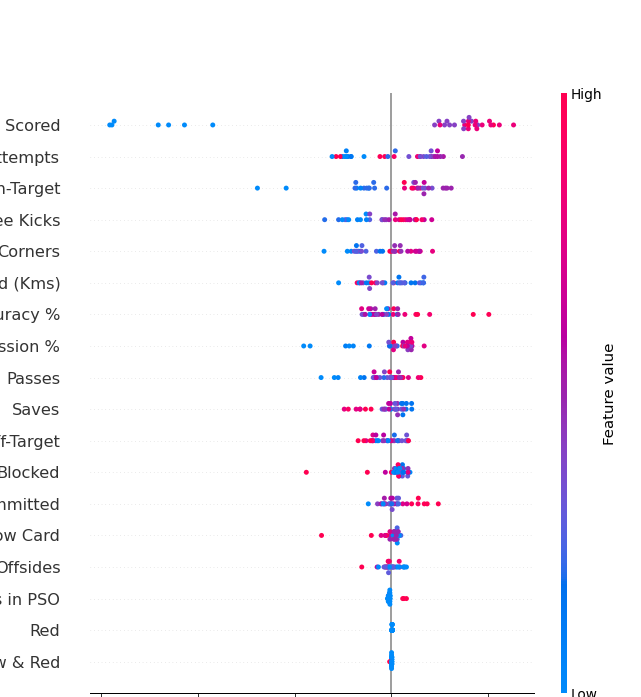

In [92]:
# Create an object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate shap_values for all of X_test rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test)

Summary plots

Permutation importance creates simple numeric measures to see which features mattered to a model. But it doesn’t tell you how each features matter. If a feature has medium permutation importance, that could mean it has :

   a large effect for a few predictions, but no effect in general, or
   a medium effect for all predictions.

SHAP summary plots give us a birds-eye view of feature importance and what is driving it.

Each dot has 3 characteristics :
   
   Vertical location shows what feature it is depicting
   The color shows whether the feature was high or low for that row of the dataset
   Horizontal location shows whether the effect of that value caused a higher or lower prediction

In this specific example, the model ignored Red and Yellow & Red features. High values of goal scored caused higher predictions, and low values caused low predictions.

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). 

 By doing this for all features, we see which features drive the model's prediction a lot (such as scored), and which only effect the prediction a little (such as red). Note that when points don't fit together on the line they pile up vertically to show density. Each dot is also colored by the value of that feature from high to low.

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot above sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). 

### SHAP Dependence Contribution plots

Partial Dependence Plots to show how a single feature impacts predictions. But they don’t show the distribution of the effects for example.

by plotting the SHAP value for a feature against the actual value of the feature for all players we can see how changes in the feature's value effect the model's output. 

Note that these plots are very similar to standard partial dependence plots, but they provide the added advantage of displaying how much context matters for a feature (or in other words how much interaction terms matter). How much interaction terms effect the importance of a feature is capture by the vertical dispersion of the data points.

<IPython.core.display.Javascript object>


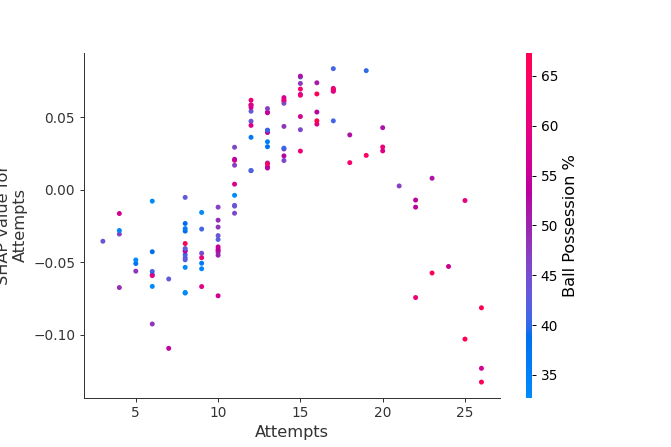

In [14]:
# Create an object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X) #test

# make plot.
shap.dependence_plot('Attempts', shap_values[1], X, interaction_index="Ball Possession %") #test

 For example attempts during a game may lower your logg odds of winning by -0.1 for some players or only -0.01 for others. Why is this? Because other features of these players effect how much attempts for winning man of the match. Note that the vertical spread narrows once you earn at 11 attempts, meaning the context of other features matters less for high attemps than low attemps. We color the datapoints with another feature that most explains the interaction effect variance. 
 
For example earning less gold is less bad if you have not died very much, but it is really bad if you also die a lot.

The y-axis in the plots below represents the SHAP value for that feature, so -4 means observing that feature lowers your log odds of winning by 4, while a value of +2 means observing that feature raises your log odds of winning by 2.

Note that these plot just explain how the XGBoost model works, not nessecarily how reality works. Since the XGBoost model is trained from observational data, it is not nessecarily a causal model, and so just because changing a factor makes the model's prediction of winning go up, does not always mean it will raise your actual chances.

<IPython.core.display.Javascript object>


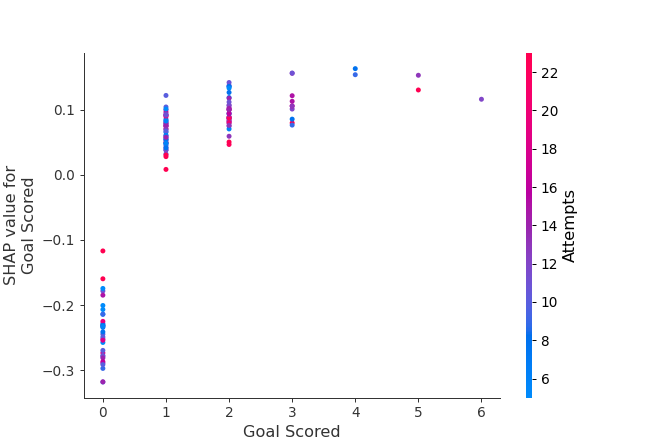

<IPython.core.display.Javascript object>


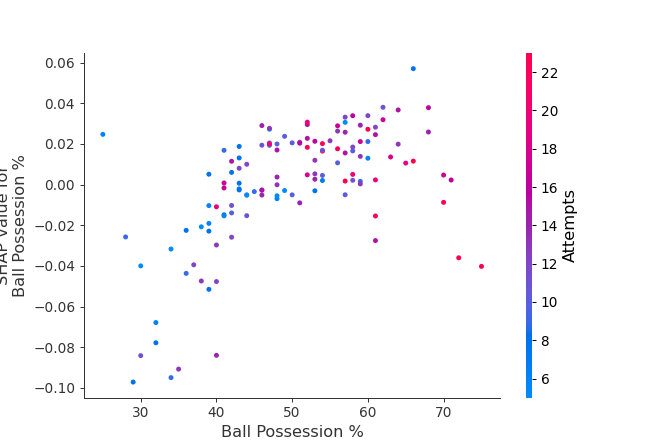

<IPython.core.display.Javascript object>


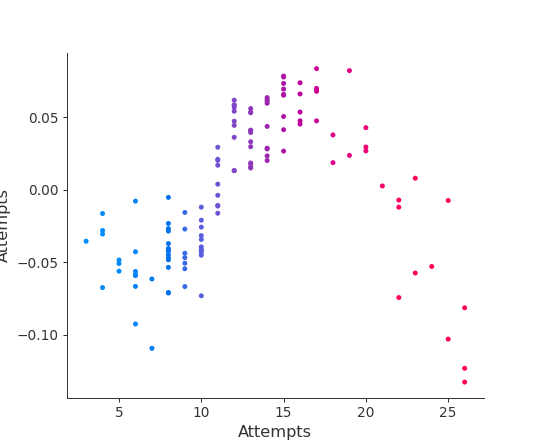

<IPython.core.display.Javascript object>


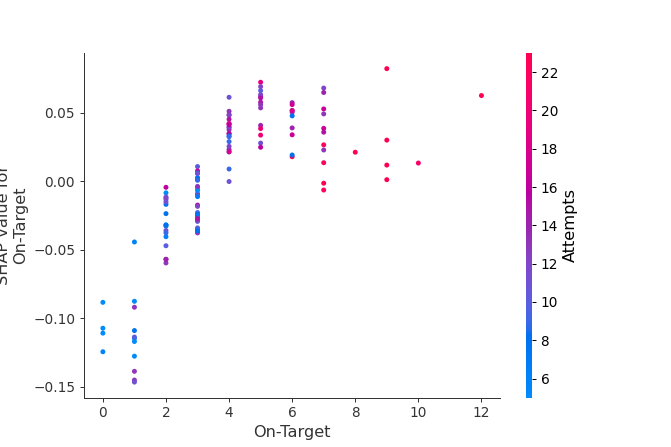

<IPython.core.display.Javascript object>


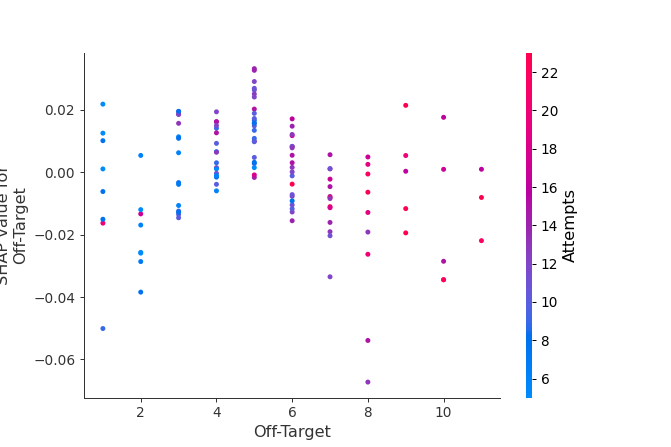

<IPython.core.display.Javascript object>


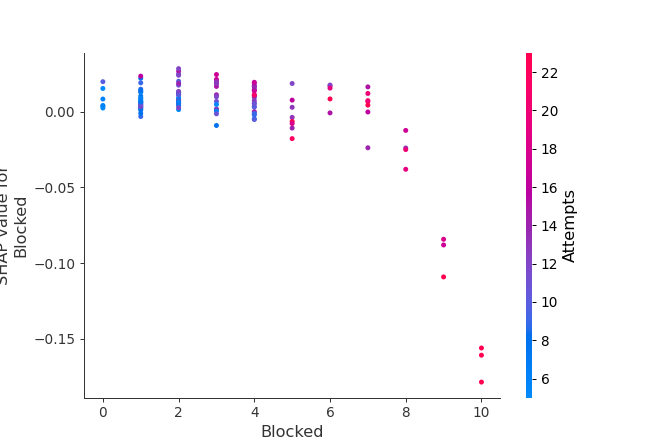

<IPython.core.display.Javascript object>


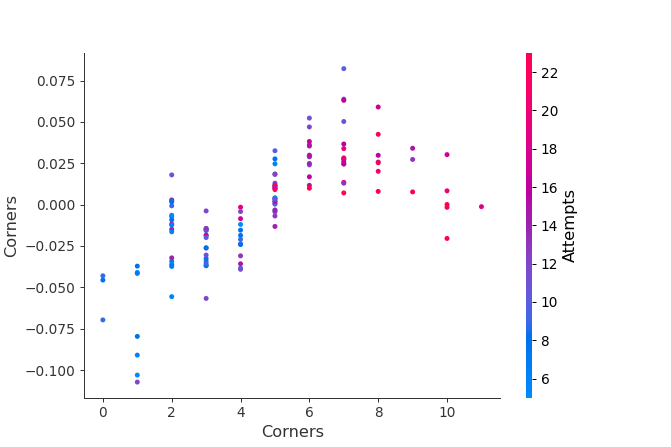

<IPython.core.display.Javascript object>


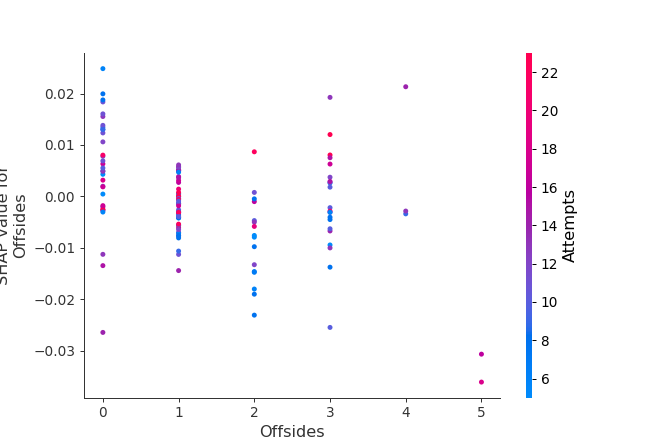

<IPython.core.display.Javascript object>


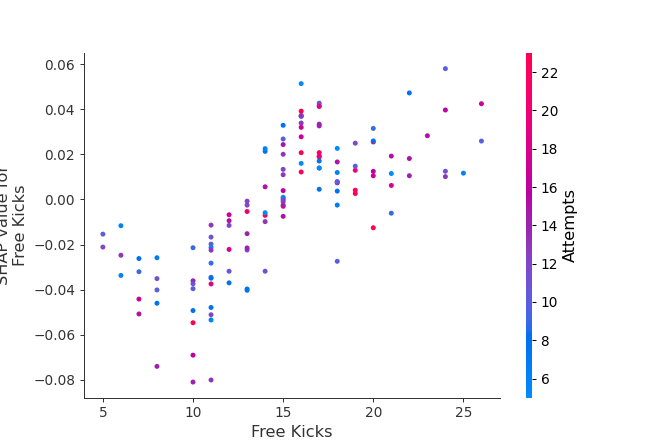

<IPython.core.display.Javascript object>


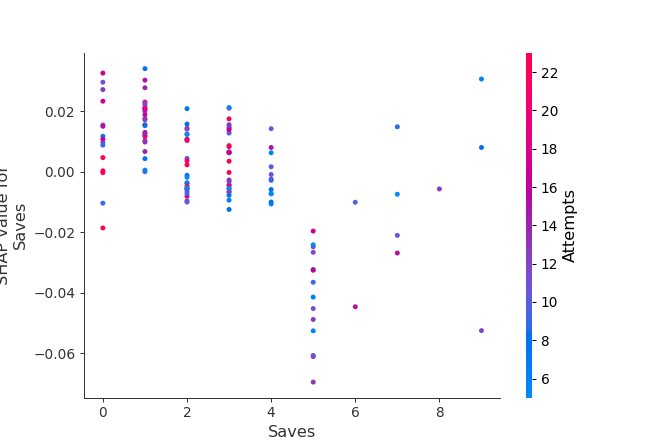

<IPython.core.display.Javascript object>


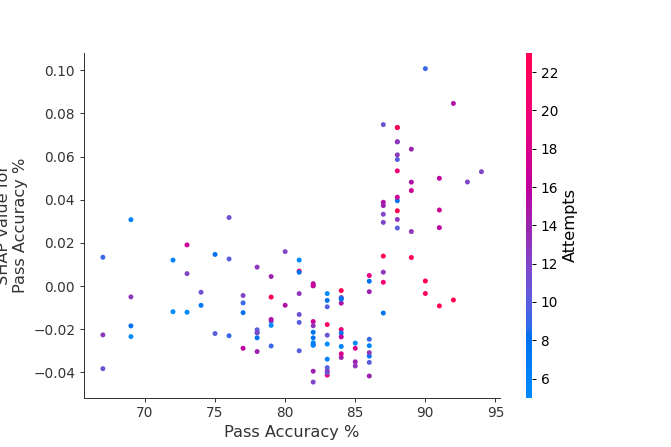

<IPython.core.display.Javascript object>


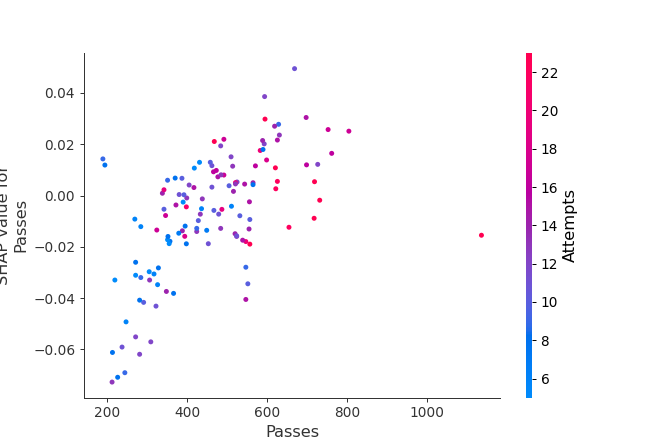

<IPython.core.display.Javascript object>


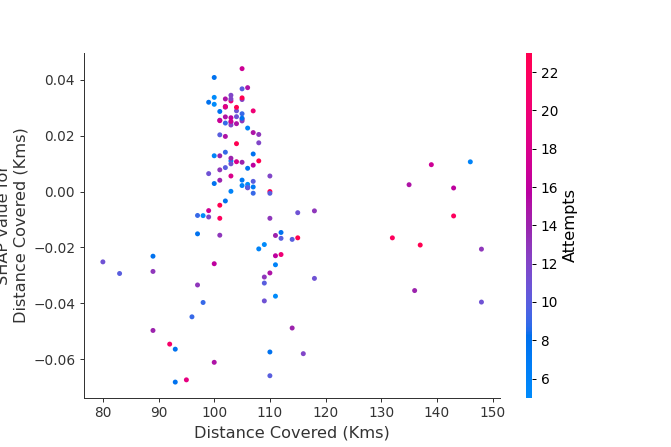

<IPython.core.display.Javascript object>


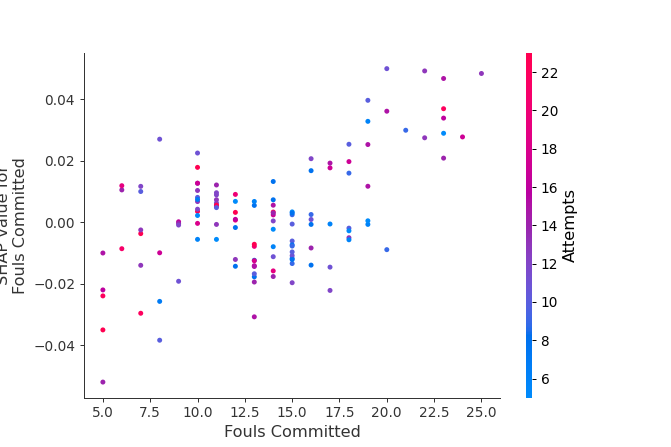

<IPython.core.display.Javascript object>


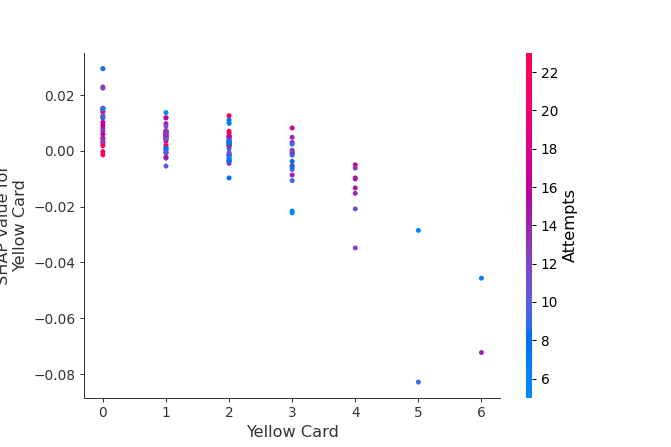

<IPython.core.display.Javascript object>


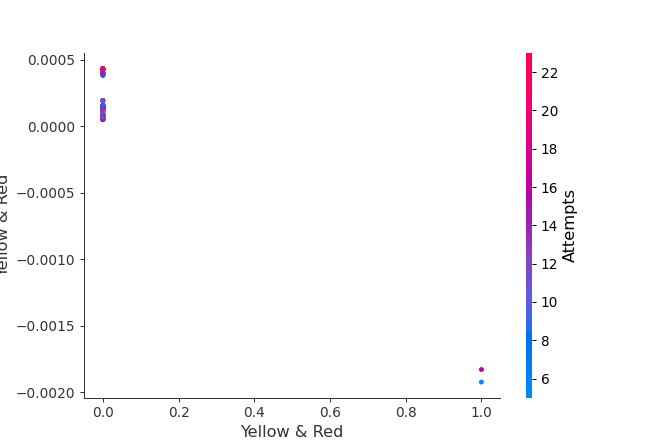

<IPython.core.display.Javascript object>


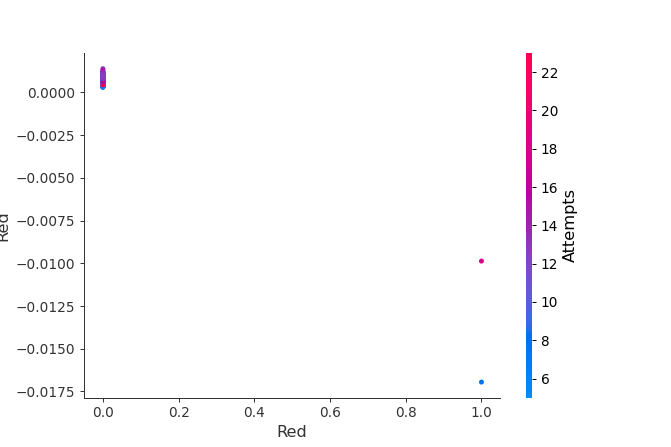

<IPython.core.display.Javascript object>


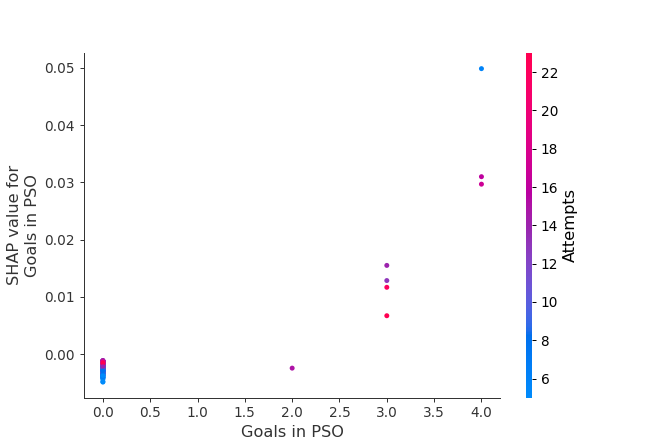

In [107]:
for name in X.columns:
    shap.dependence_plot(name, shap_values[1], X, interaction_index="attempts")

In [ ]:
# Create an object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)
for name in X.columns:
    shap.dependence_plot(name, shap_values[1], X, interaction_index="Attempts")

In this case coloring by Ball possession % highlights that the attem has less impact on home price for areas with a high RAD value.

Each dot represents a row of data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The fact this slopes upward says that the more you possess the ball, the higher the model’s prediction is for winning the Man of the Match award.

The spread suggests that other features must interact with Ball Possession %. For the same ball possession, we encounter SHAP values that range from -0.05 to 0.07. 

We can also notice outliers that stand out spatially as being far away from the upward trend

We can find an interpretation for this: In general, having the ball increases a team’s chance of having their player win the award. But if they only score one goal, that trend reverses and the award judges may penalize them for having the ball so much if they score that little.

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

## Summary plots

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

<IPython.core.display.Javascript object>


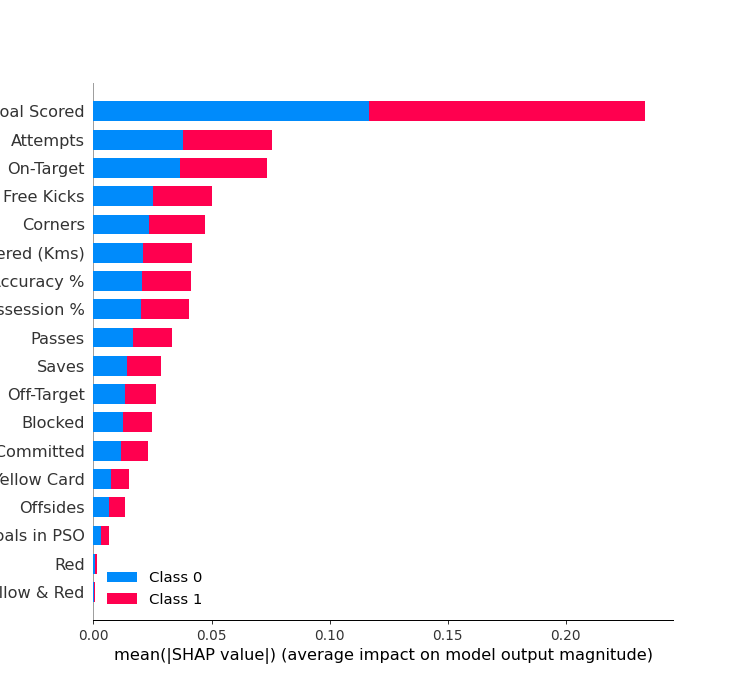

In [94]:
shap.summary_plot(shap_values, X, plot_type="bar")

### Interaction plots

In [97]:
shap.dependence_plot(("Age", "White blood cells"), shap_interaction_values, X.iloc[:2000,:], display_features=X_display.iloc[:2000,:])

NameError: name 'shap_interaction_values' is not defined

SHAP interaction values are a generalization of SHAP values to higher order interactions. 

Fast exact computation of pairwise interactions are implemented in the latest version of XGBoost with the pred_interactions flag. With this flag XGBoost returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. The main effects are similar to the SHAP values you would get for a linear model, and the interaction effects captures all the higher-order interactions are divide them up among the pairwise interaction terms. Note that the sum of the entire interaction matrix is the difference between the model's current output and expected output, and so the interaction effects on the off-diagonal are split in half (since there are two of each). When plotting interaction effects the SHAP package automatically multiplies the off-diagonal values by two to get the full interaction effect.

### SHAP Interaction Value Summary Plot

A summary plot of a SHAP interaction value matrix plots a matrix of summary plots with the main effects on the diagonal and the interaction effects off the diagonal.

In [3]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(Xx)

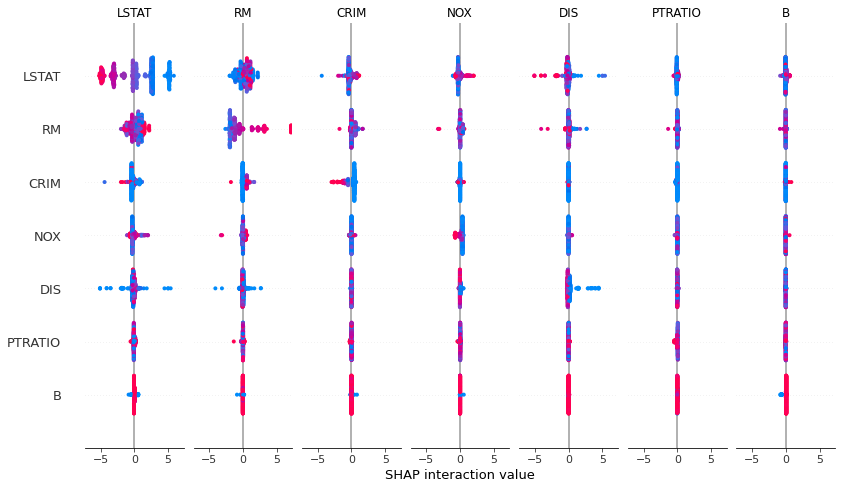

In [5]:
shap.summary_plot(shap_interaction_values, Xx)

### SHAP Interaction Value Dependence Plots

Running a dependence plot on the SHAP interaction values a allows us to separately observe the main effects and the interaction effects.

Below we plot the main effects for age and some of the interaction effects for age. It is informative to compare the main effects plot of age with the earlier SHAP value plot for age. The main effects plot has no vertical dispersion because the interaction effects are all captured in the off-diagonal terms.

<IPython.core.display.Javascript object>


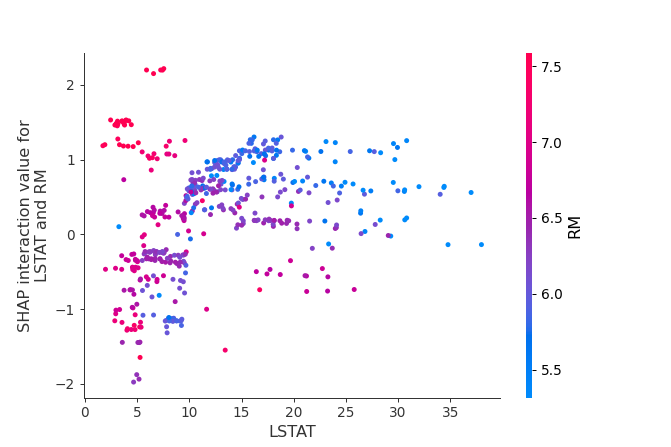

In [11]:
shap.dependence_plot(("LSTAT", "RM"),shap_interaction_values, Xx)

Now we plot the interaction effects involving age. These effects capture all of the vertical dispersion that was present in the original SHAP plot but is missing from the main effects plot above. The plot below involving age and sex shows that the sex-based death risk gap varies by age and peaks at age 60.

In [13]:
import matplotlib.pylab as pl
import numpy as np

<IPython.core.display.Javascript object>


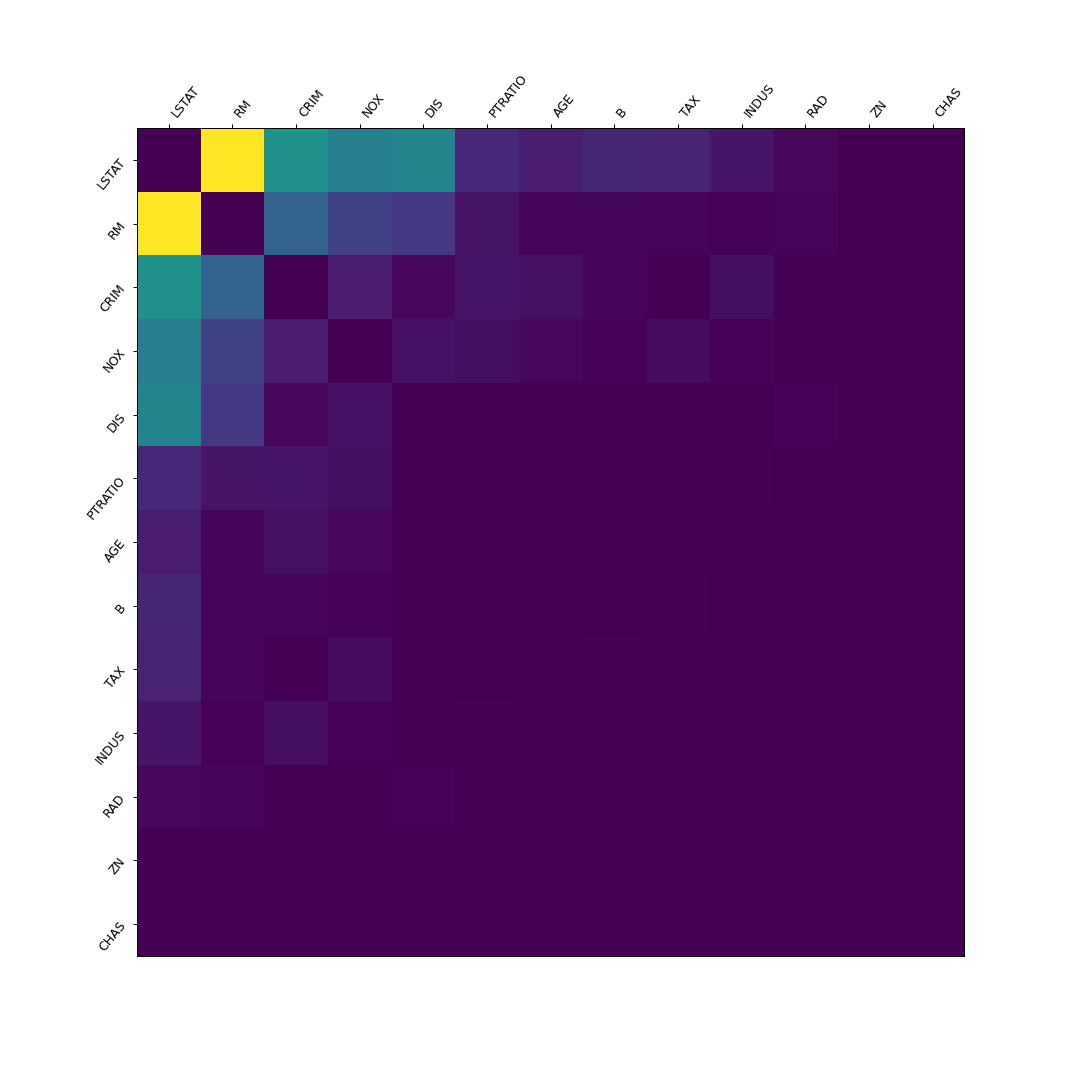

In [14]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), Xx.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), Xx.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()